Purpose
-------
    Assess biogeochemical fields from ACCESS-OM2-WOMBATlite 
    
    We use monthly climatologies for assessment (not specific years)
    
    The fields we are assessing are:
        - Surface nutrients (NO3, dFe)          --> World Ocean Atlas 2023 and Huang et al. 2022 Frontiers in Marine Science
        - Oxygen at 250 metres                  --> World Ocean Atlas 2023 and GOBAI-O2 (Sharp et al 2023 Earth System Science Data)
        - Depth of the oxygen minimum           --> World Ocean Atlas 2023 and GOBAI-O2 (Sharp et al 2023 Earth System Science Data)
        - Depth of the nitracline               --> World Ocean Atlas 2023
        - Surface Chlorophyll & POC             --> Copernicus Marine Service (CMEMS) neural network (Sauzede et al. 2016 JGR: Oceans)
        - Depth integrated Chlorophyll & POC    --> Copernicus Marine Service (CMEMS) neural network (Sauzede et al. 2016 JGR: Oceans)
        - Depth of max Chlorophyll and POC      --> Copernicus Marine Service (CMEMS) neural network (Sauzede et al. 2016 JGR: Oceans)
        - Net Primary Production                --> Carbon-based productivity model (CbPM) 
        - Primary nutrient limitation (N or Fe) --> Browning & Moore 2023 Nature Communications
        - Zooplankton specific grazing rate     --> Rohr et al (in prep)
        - Max annual chlorophyll during bloom   --> Nicholson et al., 2024

    For WOMBAT-midd
        - Nano- to Micro-phytoplankton ratio                --> Kostadinov et al. 2010
        - Depth-integrated nitrogen fixation rate           --> Shao et al., 2024
        - POC flux rate                                     --> Mouw et al., 2016
        


## imports

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import xarray as xr
import scipy as sci
import h5py as h5

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

# regridding package
import xesmf as xe

# statistics package
import skill_metrics as sm


# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("xarray version =", xr.__version__)
print("scipy version =", sci.__version__)
print("h5py version =", h5.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("xesmf version =", xe.__version__)


moddir = "/g/data/vn19/pjb581/SOCO2exps"
obsdir = "/g/data/es60/observations"
os.chdir(obsdir)


python version = 3.10.
numpy version = 1.26.4
pandas version = 2.2.1
xarray version = 2023.6.0
scipy version = 1.12.0
h5py version = 3.9.0
matplotlib version = 3.8.0
cmocean version = v3.0.3
cartopy version = 0.22.0
xesmf version = 0.8.5


In [2]:
import warnings
warnings.filterwarnings('ignore')

# start up a dask client

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34061,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:42515,Total threads: 1
Dashboard: /proxy/39655/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:35197,


## choose regular grid coordinates for all regridding and model-data comparision

In [4]:
ds_out = xe.util.grid_global(1,1)

lon_reg = ds_out.coords['lon']
lat_reg = ds_out.coords['lat']



## import nutrient observations

In [5]:

os.chdir(obsdir)

# WOA 2023 Nitrate
nan_woa = xr.open_dataset("woa23_all_n00_01.nc", decode_times=False)['n_an'].squeeze()
n01_woa = xr.open_dataset("woa23_all_n01_01.nc", decode_times=False)['n_an'].squeeze()
n02_woa = xr.open_dataset("woa23_all_n02_01.nc", decode_times=False)['n_an'].squeeze()
n03_woa = xr.open_dataset("woa23_all_n03_01.nc", decode_times=False)['n_an'].squeeze()
n04_woa = xr.open_dataset("woa23_all_n04_01.nc", decode_times=False)['n_an'].squeeze()
n05_woa = xr.open_dataset("woa23_all_n05_01.nc", decode_times=False)['n_an'].squeeze()
n06_woa = xr.open_dataset("woa23_all_n06_01.nc", decode_times=False)['n_an'].squeeze()
n07_woa = xr.open_dataset("woa23_all_n07_01.nc", decode_times=False)['n_an'].squeeze()
n08_woa = xr.open_dataset("woa23_all_n08_01.nc", decode_times=False)['n_an'].squeeze()
n09_woa = xr.open_dataset("woa23_all_n09_01.nc", decode_times=False)['n_an'].squeeze()
n10_woa = xr.open_dataset("woa23_all_n10_01.nc", decode_times=False)['n_an'].squeeze()
n11_woa = xr.open_dataset("woa23_all_n11_01.nc", decode_times=False)['n_an'].squeeze()
n12_woa = xr.open_dataset("woa23_all_n12_01.nc", decode_times=False)['n_an'].squeeze()

lon_woa = xr.open_dataset("woa23_all_n00_01.nc", decode_times=False)['n_an'].coords['lon']
lat_woa = xr.open_dataset("woa23_all_n00_01.nc", decode_times=False)['n_an'].coords['lat']
dep_woa = xr.open_dataset("woa23_all_n00_01.nc", decode_times=False)['n_an'].coords['depth']

# Dissolved Iron (Huang, Y.,Tagliabue, A., & Cassar, N. (2022). Data-driven modeling of dissolved iron in the global ocean. Frontier in Marine Science))
dfe_Huang = xr.open_dataset("Monthly_dFe.nc")['dFe_RF']
dfe_Huang = dfe_Huang.isel(Month=slice(0,12)).rename({"Month":"month", "Depth":"depth"})
lon_Huang = dfe_Huang.coords['Longitude']
lat_Huang = dfe_Huang.coords['Latitude']



## create climatology of NO3

In [6]:

no3_woa = xr.concat([n01_woa, n02_woa, n03_woa, n04_woa, n05_woa, n06_woa, n07_woa, n08_woa, n09_woa, n10_woa, n11_woa, n12_woa], dim="month")
nan_woa = xr.concat([nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa], dim="month")
no3_woa = no3_woa.rename({"time":"month"}).assign_coords({"month": np.arange(1,13,1)})
nan_woa = nan_woa.rename({"time":"month"}).assign_coords({"month": np.arange(1,13,1)})
no3_woa = xr.concat([no3_woa, nan_woa.isel(depth=slice(43,102))], dim='depth')

del n01_woa, n02_woa, n03_woa, n04_woa, n05_woa, n06_woa, n07_woa, n08_woa, n09_woa, n10_woa, n11_woa, n12_woa, nan_woa


## regrid the WOA data

In [7]:
lon_woa, lat_woa = np.meshgrid(lon_woa, lat_woa)

ds_in = xr.Dataset(
    {'no3_woa': ( ('month', 'y', 'x'), no3_woa.isel(depth=0).values),
     },
    coords={"lon": (['y','x'], lon_woa),
            "lat": (['y','x'], lat_woa),
            "month": (['month'], no3_woa.coords['month'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
no3_woa_reg = regridder(ds_in['no3_woa'])

### regrid the Huang data
lon_Huang, lat_Huang = np.meshgrid(lon_Huang, lat_Huang)

ds_in = xr.Dataset(
    {'dfe_Huang': ( ('month', 'y', 'x'), dfe_Huang.isel(depth=0).values),
     },
    coords={"lon": (['y','x'], lon_Huang),
            "lat": (['y','x'], lat_Huang),
            "month": (['month'], dfe_Huang.coords['month'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
dfe_Huang_reg = regridder(ds_in['dfe_Huang'])


## get the Copernicus 3D Chlorophyll dataset

In [8]:

chl01_cop = xr.open_dataset("cmems_obs_glo_bgc3d_rep_clim_01_P20210906.nc", decode_times=True)['chl']
chl02_cop = xr.open_dataset("cmems_obs_glo_bgc3d_rep_clim_02_P20210906.nc", decode_times=True)['chl']
chl03_cop = xr.open_dataset("cmems_obs_glo_bgc3d_rep_clim_03_P20210906.nc", decode_times=True)['chl']
chl04_cop = xr.open_dataset("cmems_obs_glo_bgc3d_rep_clim_04_P20210906.nc", decode_times=True)['chl']
chl05_cop = xr.open_dataset("cmems_obs_glo_bgc3d_rep_clim_05_P20210906.nc", decode_times=True)['chl']
chl06_cop = xr.open_dataset("cmems_obs_glo_bgc3d_rep_clim_06_P20210906.nc", decode_times=True)['chl']
chl07_cop = xr.open_dataset("cmems_obs_glo_bgc3d_rep_clim_07_P20210906.nc", decode_times=True)['chl']
chl08_cop = xr.open_dataset("cmems_obs_glo_bgc3d_rep_clim_08_P20210906.nc", decode_times=True)['chl']
chl09_cop = xr.open_dataset("cmems_obs_glo_bgc3d_rep_clim_09_P20210906.nc", decode_times=True)['chl']
chl10_cop = xr.open_dataset("cmems_obs_glo_bgc3d_rep_clim_10_P20210906.nc", decode_times=True)['chl']
chl11_cop = xr.open_dataset("cmems_obs_glo_bgc3d_rep_clim_11_P20210906.nc", decode_times=True)['chl']
chl12_cop = xr.open_dataset("cmems_obs_glo_bgc3d_rep_clim_12_P20210906.nc", decode_times=True)['chl']

chl_cop = xr.concat([chl01_cop, chl02_cop, chl03_cop, chl04_cop, chl05_cop, chl06_cop, chl07_cop, chl08_cop, chl09_cop, chl10_cop, chl11_cop, chl12_cop], dim="time")
chl_cop = chl_cop.rename({"time":"month"})

del chl01_cop, chl02_cop, chl03_cop, chl04_cop, chl05_cop, chl06_cop, chl07_cop, chl08_cop, chl09_cop, chl10_cop, chl11_cop, chl12_cop

### grid coordinate information and depth thicknesses
lon_cop = chl_cop.coords['longitude']
lat_cop = chl_cop.coords['latitude']
dep_cop = chl_cop.coords['depth']

### get surface values and vertically integrated values
surchl_cop = chl_cop.isel(depth=0)

### get the depth maximums of Chl and POC
chmaxz_cop = xr.open_dataset("cmems_obs_glo_bgc3d_rep_clim_pomchlmax.nc", decode_times=True)['CHMAXZ'].rename({"LONGITUDE":"longitude", "LATITUDE":"latitude", "TIME":"time"})


## regrid the CMEMS-FFNN (Copernicus) Chlorophyll and POC data

In [9]:

ds_out = xe.util.grid_global(1,1)

### observations
lon_cop, lat_cop = np.meshgrid(lon_cop, lat_cop)
ds_in = xr.Dataset(
    {'surchl_cop': ( ('month', 'y', 'x'), surchl_cop.values),
     'chmaxz_cop': ( ('month', 'y', 'x'), chmaxz_cop.values),
     },
    coords={"lon": (['y','x'], lon_cop),
            "lat": (['y','x'], lat_cop),
            "month": (['month'], surchl_cop.coords['month'].values),
            }
    )

regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')

surchl_cop_reg = regridder(ds_in['surchl_cop'])
chmaxz_cop_reg = regridder(ds_in['chmaxz_cop'])

chmaxz_cop_reg = chmaxz_cop_reg.where(chmaxz_cop_reg != 0.0)

### delete the large datasets from memory
del chl_cop, surchl_cop, chmaxz_cop


## Get the Copernicus Carbon dataset and regrid

In [10]:

co201_cop = xr.open_dataset("copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850115T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co202_cop = xr.open_dataset("copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850215T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co203_cop = xr.open_dataset("copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850315T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co204_cop = xr.open_dataset("copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850415T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co205_cop = xr.open_dataset("copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850515T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co206_cop = xr.open_dataset("copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850615T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co207_cop = xr.open_dataset("copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850715T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co208_cop = xr.open_dataset("copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850815T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co209_cop = xr.open_dataset("copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850915T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co210_cop = xr.open_dataset("copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19851015T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co211_cop = xr.open_dataset("copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19851115T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co212_cop = xr.open_dataset("copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19851215T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']

co2_cop = xr.concat([co201_cop, co202_cop, co203_cop, co204_cop, co205_cop, co206_cop, co207_cop, co208_cop, co209_cop, co210_cop, co211_cop, co212_cop], dim="time")
co2_cop = co2_cop.rename({"time":"month"})
del co201_cop, co202_cop, co203_cop, co204_cop, co205_cop, co206_cop, co207_cop, co208_cop, co209_cop, co210_cop, co211_cop, co212_cop

co2_cop
lon_co2 = co2_cop.coords['longitude']
lat_co2 = co2_cop.coords['latitude']


In [11]:

ds_out = xe.util.grid_global(1,1)

### observations
lon_co2, lat_co2 = np.meshgrid(lon_co2, lat_co2)
ds_in = xr.Dataset(
    {'fgco2_cop': ( ('month', 'y', 'x'), co2_cop.values),
     },
    coords={"lon": (['y','x'], lon_co2),
            "lat": (['y','x'], lat_co2),
            "month": (['month'], co2_cop.coords['month'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
fgco2_cop_reg = regridder(ds_in['fgco2_cop'])

### delete the large datasets from memory
del co2_cop



## get (MODIS-based) NPP via CbPM

In [12]:
with h5.File('MODIS_Chl.mat', 'r') as file:
    modis_lon = np.array(file['Lon'])
    modis_lat = np.array(file['Lat'])
    modis_tim = np.array(file['time_steps'])
print("Got coordinates")
with h5.File('MODIS_Carbon_NPP.mat', 'r') as file:
    modis_npp = np.array(file['NPP'])
print("Got NPP")


ds_in = xr.Dataset({
     'modis_npp': ( ('day', 'y', 'x'), modis_npp.transpose((2,1,0))),
     },
    coords={"lon": (['y','x'], modis_lon.transpose((1,0))),
            "lat": (['y','x'], modis_lat.transpose((1,0))),
            "day": (['day'], modis_tim[:,0]),
            }
    )

print("Regridding")
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')

modis_npp_reg = regridder(ds_in['modis_npp'])


### delete the large datasets from memory
del modis_npp


Got coordinates
Got NPP
Regridding


## regrid the NPP in time to a monthly resolution for comparison with the model output

In [13]:
from datetime import datetime, timedelta

# 1. create new datetime array with dates of MODIS climatology
days_of_year = modis_tim[:,0]
year = 2005
start_date = datetime(year, 1, 1)
mons = [(start_date + timedelta(days=int(day)-1)).month for day in days_of_year]
days = [(start_date + timedelta(days=int(day)-1)).day for day in days_of_year]
year = np.ones(len(days))*2005
dates = pd.DataFrame({'year':year.astype(int), 'month':mons, 'day':days})
daycoordinate = pd.to_datetime(dates)

# 2. apply new dates to modis xarray coordinate
modis_npp_reg = modis_npp_reg.assign_coords({'day':daycoordinate.values})

# 3. set the monthly center points
month_points = pd.date_range(start=datetime(2005, 1, 1), periods=12, freq='MS') + pd.offsets.Day(14)

# 4. interpolate the data to the monthly center points and rename time coordinate
modis_npp_reg = modis_npp_reg.interp(day=month_points, method='linear').rename({'day':'month'})


## retrieve the non-gridded datsets and extract the data ready for comparison with the model

### requires some looping and binning of data into model grid boxes

#### Primary limiting nutrient

In [14]:
limitations = pd.read_excel("Browning_Moore_Bioassay_Dataset_v1.0.xlsx", skiprows=0, usecols=(2,3,24,25,26))
limitations.columns = ['Lon', 'Lat', 'Primary', 'Secondary', 'Tertiary']
limitations = limitations.drop(limitations.index[0])

### print out the unique kinds of primary limitations
print(limitations['Primary'].unique())

### drop Manganese and NaNs
limitations = limitations[limitations['Primary'] != 'Mn']
limitations = limitations.dropna(subset=['Primary'])

# N = 1
# P = 2
# Fe = 3
# Si = 4
limitations.loc[limitations['Primary'] == 'N', 'Primary'] = 2.0
limitations.loc[limitations['Primary'] == 'N_P', 'Primary'] = 1.5
limitations.loc[limitations['Primary'] == 'P', 'Primary'] = 1.0
limitations.loc[limitations['Primary'] == 'Fe', 'Primary'] = 3.0
limitations.loc[limitations['Primary'] == 'Fe_Mn', 'Primary'] = 3.0
limitations.loc[limitations['Primary'] == 'Fe_Co', 'Primary'] = 3.0
limitations.loc[limitations['Primary'] == 'Fe_Zn_sep', 'Primary'] = 3.0
limitations.loc[limitations['Primary'] == 'N_Fe', 'Primary'] = 2.5
limitations.loc[limitations['Primary'] == 'N_Fe_sep', 'Primary'] = 2.5

### print out the unique kinds of primary limitations
print(limitations['Primary'].unique())



['N' 'Fe' 'N_Fe' nan 'N_P' 'Mn' 'Fe_Mn' 'Fe_Zn_sep' 'Fe_Co' 'N_Fe_sep']
[2.0 3.0 2.5 1.5]


#### Particle fluxes

In [15]:

pocflux = pd.read_table("Mouw_2016_particle_fluxes/GO_flux.tab", skiprows=87, usecols=(1,3,4,8,9,11,15,16,17,18,40))
pocflux.columns = ['Location ID', 'Latitude', 'Longitude', 'Depth (m)', 'Datetime deployed', 'Duration (days)', 'C flux [mg/m**2/day]', 'C flux std dev', 'POC flux [mg/m**2/day]', 'POC flux std dev', 'Reference']
print("Number of unique locations with POC flux data =", len(pocflux['Location ID'].unique()))

### First, find the mean month of sampling by averaging the start and end month 
pocflux['Month_start'] = pocflux['Datetime deployed'].str[5:7].astype(float)
pocflux['Month_end'] = pocflux['Month_start'] + pocflux['Duration (days)'] / 30.0
pocflux['Month'] = (pocflux['Month_start'] + pocflux['Month_end'] ) *0.5
print(pocflux['Month_start'].min(), pocflux['Month_start'].max())
print(pocflux['Month_end'].min(), pocflux['Month_end'].max())
print(pocflux['Month'].min(), pocflux['Month'].max())

### if the average month carries over into the next year, remove 12 to account for this
pocflux.loc[pocflux['Month'] >= 12.5, 'Month'] += -12
print(pocflux['Month'].min(), pocflux['Month'].max())

# Bin the months into 13 different numerical (integer) categories representing all months (1-12) and an annual average (0)
pocflux['Month'] = pd.cut(pocflux['Month'], bins = [0.49, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 1e5]).cat.codes + 1
print(pocflux['Month'].min(), pocflux['Month'].max())
print(pocflux.loc[pocflux['Month']==0,['Datetime deployed', 'Duration (days)']])
pocflux.loc[pocflux['Month']==13, 'Month'] = 0
print(pocflux['Month'].min(), pocflux['Month'].max())

# Now find the average measured POC fluxes and the locations and months of sampling. We can therefore have multiple months of sampling at the same location.
pocflux_ave = pocflux.groupby(['Month', 'Location ID'])['POC flux [mg/m**2/day]'].mean()
pocflux_std = pocflux.groupby(['Month', 'Location ID'])['POC flux [mg/m**2/day]'].std()
pocflux_lon = pocflux.groupby(['Month', 'Location ID'])['Longitude'].mean()
pocflux_lat = pocflux.groupby(['Month', 'Location ID'])['Latitude'].mean()
pocflux_dep = pocflux.groupby(['Month', 'Location ID'])['Depth (m)'].mean()
pocflux_mon = pocflux.groupby(['Month', 'Location ID'])['Month'].mean()
pocflux_std_measured = pocflux.groupby(['Month', 'Location ID'])['POC flux std dev'].mean()



Number of unique locations with POC flux data = 674
1.0 12.0
1.0 150.76666666666668
1.0 79.88333333333334
0.5 67.88333333333334
0 13
     Datetime deployed  Duration (days)
7676               NaN            6.185
7687               NaN           10.994
7690               NaN           10.869
7736               NaN            3.771
7774               NaN           22.562
7827               NaN            2.653
7828               NaN            2.653
7829               NaN            2.653
0 12


#### Put the Limiting nutrient, poc fluxes and nitrogen fixation rates onto the model grid for comparison

In [16]:
print("binning primary limiting nutrient")
limits_reg = np.zeros((180,360))*np.nan
for xi,xx in enumerate(lon_reg[0,:].values):
    for yi,yy in enumerate(lat_reg[:,0].values):
        limxs = (limitations['Lon'] >= xx-0.5) & (limitations['Lon'] < xx+0.5)
        limys = (limitations['Lat'] >= yy-0.5) & (limitations['Lat'] < yy+0.5)
        if np.any(limxs*limys):
            tmp = limitations[limxs*limys]
            limits_reg[yi,xi] = tmp['Primary'].mean()
        else:
            continue

limits_reg = xr.DataArray(limits_reg, dims=('lat', 'lon'))
print("Number of limiting nutrient measurements before binning?", limitations['Primary'].count())
print("Number of limiting nutrient measurements after binning?", limits_reg.count().values)


print("binning particle flux dataset")

# get the vertical grid information since this dataset is in 3D (4D in time)
vgrid  = xr.open_dataset("../pjb581/wombat_files/ocean_vgrid.nc").rename({"zeta":"z", "nzv":"z"})
dep = vgrid['z'][1:-1:2]
dep_b = vgrid['z'][0::2]
dep_thick = dep_b[1::]-dep_b[0:-1]

cc = 0
pocflux_reg = np.zeros((13,50,180,360))*np.nan
for xi,xx in enumerate(lon_reg.values[0,:]):
    limxs = (pocflux_lon >= xx-0.5) & (pocflux_lon < xx+0.5)
    if np.any(limxs) == False:
        continue
    else:
        tmp1_ave = pocflux_ave[limxs]
        tmp1_lat = pocflux_lat[limxs]
        tmp1_dep = pocflux_dep[limxs]
        tmp1_mon = pocflux_mon[limxs]
    
    for yi,yy in enumerate(lat_reg.values[:,0]):
        limys = (tmp1_lat >= yy-0.5) & (tmp1_lat < yy+0.5)
        if np.any(limys) == False:
            continue
        else:
            tmp2_ave = tmp1_ave[limys]
            tmp2_dep = tmp1_dep[limys]
            tmp2_mon = tmp1_mon[limys]
        
        for zi,zz in enumerate(dep.values):
            limzs = (tmp2_dep >= dep_b.values[zi]) & (tmp2_dep < dep_b.values[zi+1])
            if np.any(limzs) == False:
                continue
            else:
                tmp3_ave = tmp2_ave[limzs]
                tmp3_mon = tmp2_mon[limzs]
                
            for mm in np.arange(0,13,1):
                limms = tmp3_mon.astype(int) == mm
                if np.any(limms) == False:
                    continue
                else:
                    tmp4_ave = tmp3_ave[limms]
                    pocflux_reg[mm,zi,yi,xi] = tmp4_ave.mean()
                    #print("Found a POC flux measurement at", mm,xi,yi,zi, "with %i values"%(tmp4_ave.count()))
                    cc += 1

pocflux_reg = xr.DataArray(pocflux_reg, dims=('month', 'depth', 'lat', 'lon'))
print("Number of POC flux measurements before binning?", pocflux_ave.count())
print("Number of POC flux measurements after binning?", pocflux_reg.count().values)


binning primary limiting nutrient
Number of limiting nutrient measurements before binning? 942
Number of limiting nutrient measurements after binning? 137
binning particle flux dataset
Number of POC flux measurements before binning? 2399
Number of POC flux measurements after binning? 1986


### save the measured POC flux to an excel file for later extraction

In [17]:
pocflux_new = pd.DataFrame({'Lon':pocflux_lon.values,
                            'Lat':pocflux_lat.values,
                            'Dep':pocflux_dep.values,
                            'Mon':pocflux_mon.values,
                            'flux_mean':pocflux_ave.values,
                            'flux_std':pocflux_std.values,
                            })

pocflux_new.to_excel("pocflux_Mouw2016.xlsx")

## make figure for WOMBAT-lite paper

In [18]:
from cartopy.util import add_cyclic_point

no3_cyclic, lon_cyclic = add_cyclic_point(no3_woa.isel(depth=0).mean(dim='month'), coord=no3_woa.coords['lon'])
dfe_cyclic, lon_dfecyc = add_cyclic_point(dfe_Huang.isel(depth=0).mean(dim='month'), coord=dfe_Huang.coords['Longitude'])

### assign single dimension to longitudes and latitudes
lons = lon_reg.isel(y=0).values
lats = lat_reg.isel(x=0).values
surchl_cop_reg2 = xr.DataArray(
    surchl_cop_reg.values,
    dims=['month', 'lat', 'lon'],
    coords={"month": surchl_cop_reg.coords['month'], "lat":lats, "lon":lons}
)
chmaxz_cop_reg2 = xr.DataArray(
    chmaxz_cop_reg.values,
    dims=['month', 'lat', 'lon'],
    coords={"month": chmaxz_cop_reg.coords['month'], "lat":lats, "lon":lons}
)
modis_npp_reg2 = xr.DataArray(
    modis_npp_reg.values,
    dims=['month', 'lat', 'lon'],
    coords={"month": modis_npp_reg.coords['month'], "lat":lats, "lon":lons}
)
fgco2_cop_reg2 = xr.DataArray(
    fgco2_cop_reg.values,
    dims=['month', 'lat', 'lon'],
    coords={"month": fgco2_cop_reg.coords['month'], "lat":lats, "lon":lons}
)

chl_cyclic, lon_cyclic = add_cyclic_point(surchl_cop_reg2.mean(dim='month'), coord=surchl_cop_reg2.coords['lon'])
chm_cyclic, lon_cyclic = add_cyclic_point(chmaxz_cop_reg2.mean(dim='month'), coord=chmaxz_cop_reg2.coords['lon'])
npp_cyclic, lon_cyclic = add_cyclic_point(modis_npp_reg2.mean(dim='month'), coord=modis_npp_reg2.coords['lon'])
co2_cyclic, lon_cyclic = add_cyclic_point(fgco2_cop_reg2.mean(dim='month'), coord=fgco2_cop_reg2.coords['lon'])

np.shape(dfe_cyclic)

(147, 358)

In [19]:
### add some additional points to the pocflux database so that the map looks normal

pocflux_new.loc[len(pocflux_new)] = [179.0, -89.75, 10.0, 12.0, 0.1, 0.0]
pocflux_new.loc[len(pocflux_new)] = [179.0, 89.75, 10.0, 12.0, 0.1, 0.0]
pocflux_new.loc[len(pocflux_new)] = [0.1, 0.0, 10.0, 12.0, 0.1, 0.0]


In [20]:
pocflux_new['Mon'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

Text(0.05, 0.95, 'h')

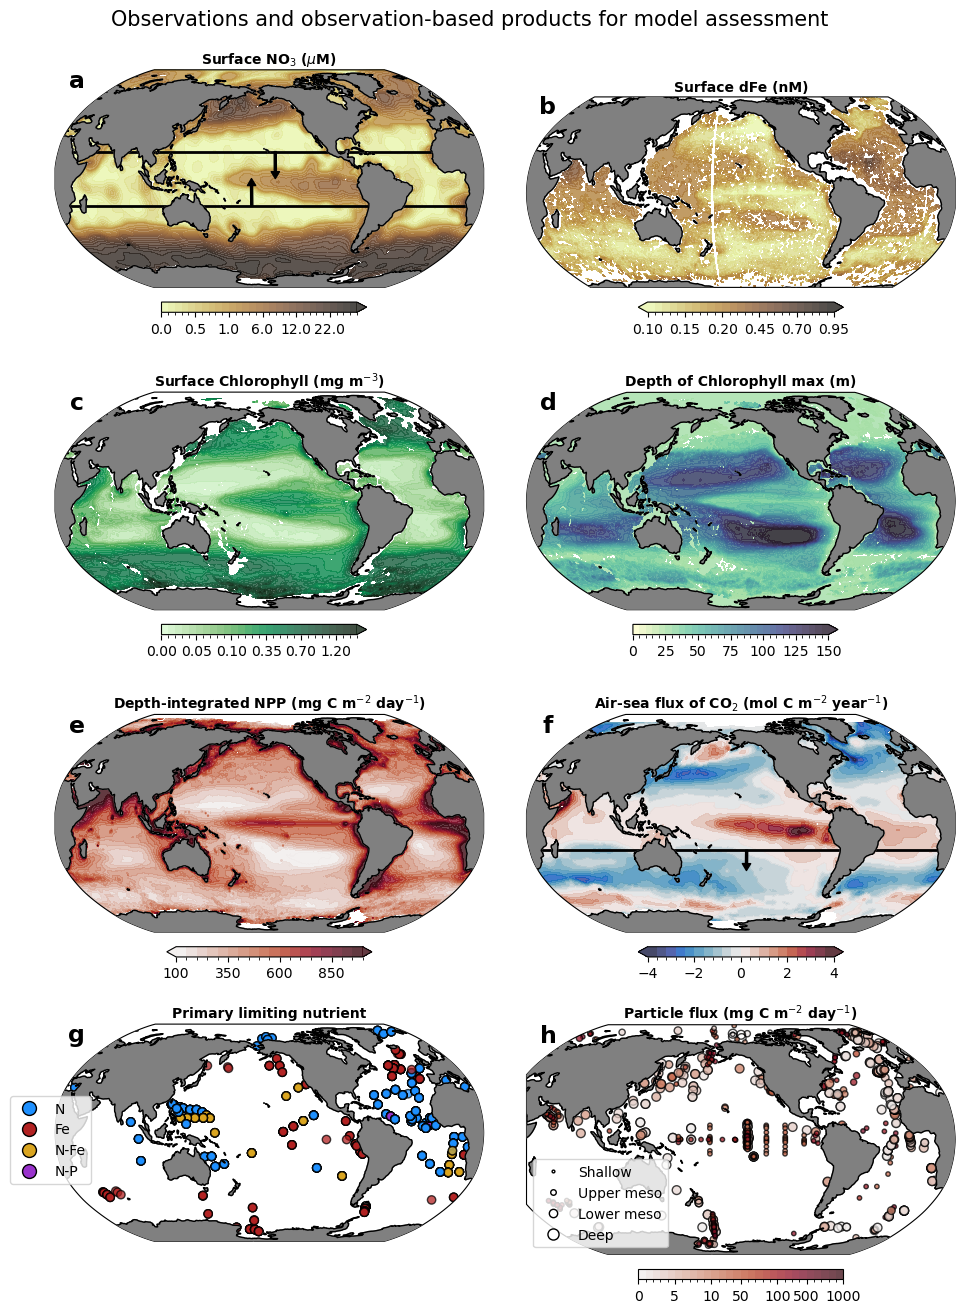

In [21]:
fslab = 15
fstic = 13

import matplotlib.lines as mlines
from cartopy.util import add_cyclic_point

proj = ccrs.Robinson(central_longitude=205)

colmap1 = lighten(cmo.turbid, 0.8)
colmap2 = lighten(cmo.turbid, 0.8)
colmap3 = lighten(cmo.algae, 0.8)
colmap4 = lighten(cmo.deep, 0.8)
colmap5 = lighten(cmo.amp, 0.8)
colmap6 = lighten(cmo.balance, 0.8)
colmap7 = {2.0:'dodgerblue', 3.0:'firebrick', 2.5:'goldenrod', 1.5:'darkorchid'}
colmap8 = lighten(cmo.amp, 0.8)


# surface NO3
levs1 = np.concatenate( (np.arange(0,1,0.1), np.arange(1,10,1), np.arange(10,30.1,2)) )
norm1 = mcolors.BoundaryNorm(levs1, ncolors=256)

# Surface dFe
levs2 = np.concatenate( (np.arange(0.1,0.2,0.01), np.arange(0.2,1,0.05)) )
norm2 = mcolors.BoundaryNorm(levs2, ncolors=256)

# Surface chlorophyll
levs3 = np.concatenate((np.arange(0,0.1,0.01), np.arange(0.1,0.5,0.05), np.arange(0.5,1.51,0.1)))
norm3 = mcolors.BoundaryNorm(levs3, ncolors=256)

# Depth of max Chl
levs4 = np.arange(0,151,5)
norm4 = mcolors.BoundaryNorm(levs4, ncolors=256)

# Depth-integrated NPP (MODIS-based CbPM algorithm)
levs5 = np.arange(100,1001,50)
norm5 = mcolors.BoundaryNorm(levs5, ncolors=256)

# Downward flux of CO2
levs6 = np.arange(-4,4.1,0.4)
norm6 = mcolors.BoundaryNorm(levs6, ncolors=256)

# Primary limiting nutrient
colors7 = [colmap7[lim] for lim in limitations['Primary']] 

# Downward flux of POC through ocean interior
levs8 = np.concatenate((np.arange(0,10,1), np.arange(10,100,10), np.arange(100,1001,100)))
norm8 = mcolors.BoundaryNorm(levs8, ncolors=256)


fig = plt.figure(figsize=(10,14))
gs = GridSpec(4, 2)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[0,1], projection=proj)
ax3 = plt.subplot(gs[1,0], projection=proj)
ax4 = plt.subplot(gs[1,1], projection=proj)
ax5 = plt.subplot(gs[2,0], projection=proj)
ax6 = plt.subplot(gs[2,1], projection=proj)
ax7 = plt.subplot(gs[3,0], projection=proj)
ax8 = plt.subplot(gs[3,1], projection=proj)

p1 = ax1.contourf(lon_cyclic, lats, no3_cyclic, transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1, levels=levs1, extend='max')
p2 = ax2.contourf(lon_dfecyc, dfe_Huang.coords['Latitude'], dfe_cyclic, transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm2, levels=levs2, extend='both')
p3 = ax3.contourf(lon_cyclic, lats, chl_cyclic, transform=ccrs.PlateCarree(), cmap=colmap3, norm=norm3, levels=levs3, extend='max')
p4 = ax4.contourf(lon_cyclic, lats, chm_cyclic, transform=ccrs.PlateCarree(), cmap=colmap4, norm=norm4, levels=levs4, extend='max')
p5 = ax5.contourf(lon_cyclic, lats, npp_cyclic, transform=ccrs.PlateCarree(), cmap=colmap5, norm=norm5, levels=levs5, extend='both')
p6 = ax6.contourf(lon_cyclic, lats, co2_cyclic*(-1), transform=ccrs.PlateCarree(), cmap=colmap6, norm=norm6, levels=levs6, extend='both')


ax7.scatter(limitations['Lon'], limitations['Lat'], c=colors7, transform=ccrs.PlateCarree(), alpha=0.75, edgecolor='k')
points = [mlines.Line2D([], [], color=colmap7[2.0], marker='o', markeredgecolor='k', linestyle='None', markersize=10, label='N'),
          mlines.Line2D([], [], color=colmap7[3.0], marker='o', markeredgecolor='k', linestyle='None', markersize=10, label='Fe'),
          mlines.Line2D([], [], color=colmap7[2.5], marker='o', markeredgecolor='k', linestyle='None', markersize=10, label='N-Fe'),
          mlines.Line2D([], [], color=colmap7[1.5], marker='o', markeredgecolor='k', linestyle='None', markersize=10, label='N-P')]
ax7.legend(handles=points, bbox_to_anchor=(0.1,0.7))


### make sizes of markers based on depth info
pocflux_cat = pd.cut(pocflux_dep.groupby('Location ID').mean(), bins=[0,150,500,1000,10000], labels=['Shallow', 'Upper mesopelagic', 'Lower mesopelagic', 'Deep'])
pocflux_siz = (pocflux_cat.cat.codes +1)*10
p8 = ax8.scatter(pocflux_lon.groupby('Location ID').mean(), pocflux_lat.groupby('Location ID').mean(), c=pocflux_ave.groupby('Location ID').mean(), 
                   s=pocflux_siz, transform=ccrs.PlateCarree(), alpha=0.75, edgecolor='k', cmap=colmap8, norm=norm8)
points = [mlines.Line2D([], [], color='w', marker='o', markeredgecolor='k', linestyle='None', markersize=pocflux_siz.sort_values().unique()[0]*0.2, label='Shallow'),
          mlines.Line2D([], [], color='w', marker='o', markeredgecolor='k', linestyle='None', markersize=pocflux_siz.sort_values().unique()[1]*0.2, label='Upper meso'),
          mlines.Line2D([], [], color='w', marker='o', markeredgecolor='k', linestyle='None', markersize=pocflux_siz.sort_values().unique()[2]*0.2, label='Lower meso'),
          mlines.Line2D([], [], color='w', marker='o', markeredgecolor='k', linestyle='None', markersize=pocflux_siz.sort_values().unique()[3]*0.2, label='Deep')]
ax8.legend(handles=points)

ax1.add_feature(cfeature.LAND, color='grey', zorder=3)
ax1.add_feature(cfeature.COASTLINE, color='k', zorder=4)
ax2.add_feature(cfeature.LAND, color='grey', zorder=3)
ax2.add_feature(cfeature.COASTLINE, color='k', zorder=4)
ax3.add_feature(cfeature.LAND, color='grey', zorder=3)
ax3.add_feature(cfeature.COASTLINE, color='k', zorder=4)
ax4.add_feature(cfeature.LAND, color='grey', zorder=3)
ax4.add_feature(cfeature.COASTLINE, color='k', zorder=4)
ax5.add_feature(cfeature.LAND, color='grey', zorder=3)
ax5.add_feature(cfeature.COASTLINE, color='k', zorder=4)
ax6.add_feature(cfeature.LAND, color='grey', zorder=3)
ax6.add_feature(cfeature.COASTLINE, color='k', zorder=4)
ax7.add_feature(cfeature.LAND, color='grey', zorder=3)
ax7.add_feature(cfeature.COASTLINE, color='k', zorder=4)
ax8.add_feature(cfeature.LAND, color='grey', zorder=3)
ax8.add_feature(cfeature.COASTLINE, color='k', zorder=4)

### boxes around areas of interest
ax1.plot((-180.0,180.0),(-20,-20), transform=ccrs.PlateCarree(), color='k', linewidth=2)
ax1.plot((-180.0,180.0),(20,20), transform=ccrs.PlateCarree(), color='k', linewidth=2)
ax6.plot((-180.0,180.0),(-20,-20), transform=ccrs.PlateCarree(), color='k', linewidth=2)

ax1.annotate(
    '',  # Text to display
    xy=(190.0,0.0),   # The arrowhead location
    xytext=(190.0,-20.0),  # The starting point of the arrow
    size=2,
    arrowprops=dict(facecolor='k', headwidth=6, shrink=0.0, headlength=5, width=1.5),
    transform=ccrs.PlateCarree()
)
ax1.annotate(
    '',  # Text to display
    xy=(210.0,0.0),   # The arrowhead location
    xytext=(210.0,20.0),  # The starting point of the arrow
    size=2,
    arrowprops=dict(facecolor='k', headwidth=6, shrink=0.0, headlength=5, width=1.5),
    transform=ccrs.PlateCarree()
)
ax6.annotate(
    '',  # Text to display
    xy=(210.0,-35.0),   # The arrowhead location
    xytext=(210.0,-20.0),  # The starting point of the arrow
    size=2,
    arrowprops=dict(facecolor='k', headwidth=6, shrink=0.0, headlength=5, width=1.5),
    transform=ccrs.PlateCarree()
)

#ax2.set_extent([0,360,-90,90], crs=ccrs.PlateCarree())

xx = 0.5; yy = 1.05
plt.text(xx,yy, 'Surface NO$_3$ ($\mu$M)', ha='center', va='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy, 'Surface dFe (nM)', ha='center', va='center', fontweight='bold', transform=ax2.transAxes)
plt.text(xx,yy, 'Surface Chlorophyll (mg m$^{-3}$)', ha='center', va='center', fontweight='bold', transform=ax3.transAxes)
plt.text(xx,yy, 'Depth of Chlorophyll max (m)', ha='center', va='center', fontweight='bold', transform=ax4.transAxes)
plt.text(xx,yy, 'Depth-integrated NPP (mg C m$^{-2}$ day$^{-1}$)', ha='center', va='center', fontweight='bold', transform=ax5.transAxes)
plt.text(xx,yy, 'Air-sea flux of CO$_2$ (mol C m$^{-2}$ year$^{-1}$)', ha='center', va='center', fontweight='bold', transform=ax6.transAxes)
plt.text(xx,yy, 'Primary limiting nutrient', ha='center', va='center', fontweight='bold', transform=ax7.transAxes)
plt.text(xx,yy, 'Particle flux (mg C m$^{-2}$ day$^{-1}$)', ha='center', va='center', fontweight='bold', transform=ax8.transAxes)

plt.text(0.465, 0.95, 'Observations and observation-based products for model assessment', va='center', ha='center', fontsize=15, transform=fig.transFigure)

plt.subplots_adjust(left=0.05, bottom=0.05, top=0.95, right=0.95, hspace=0.1, wspace=0.1)

plt.colorbar(p1, ax=ax1, orientation='horizontal', ticks=levs1[::5], fraction=0.035, pad=0.05)
plt.colorbar(p2, ax=ax2, orientation='horizontal', ticks=levs2[::5], fraction=0.035, pad=0.05)
plt.colorbar(p3, ax=ax3, orientation='horizontal', ticks=levs3[::5], fraction=0.035, pad=0.05)
plt.colorbar(p4, ax=ax4, orientation='horizontal', ticks=levs4[::5], fraction=0.035, pad=0.05)
plt.colorbar(p5, ax=ax5, orientation='horizontal', ticks=levs5[::5], fraction=0.035, pad=0.05)
plt.colorbar(p6, ax=ax6, orientation='horizontal', ticks=levs6[::5], fraction=0.035, pad=0.05)
#plt.colorbar(p7, ax=ax7, orientation='horizontal', ticks=levs7[::5], fraction=0.035, pad=0.05)
plt.colorbar(p8, ax=ax8, orientation='horizontal', ticks=levs8[[0,5,10,14,19,23,28]], fraction=0.035, pad=0.05)


xx = 0.05
yy = 0.95
plt.text(xx,yy, 'a', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax1.transAxes)
plt.text(xx,yy, 'b', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax2.transAxes)
plt.text(xx,yy, 'c', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax3.transAxes)
plt.text(xx,yy, 'd', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax4.transAxes)
plt.text(xx,yy, 'e', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax5.transAxes)
plt.text(xx,yy, 'f', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax6.transAxes)
plt.text(xx,yy, 'g', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax7.transAxes)
plt.text(xx,yy, 'h', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax8.transAxes)



In [22]:

fig.savefig("/home/581/pjb581/gtracer_optimisation/targets.png", dpi=300)
fig.savefig("/home/581/pjb581/gtracer_optimisation/targets.pdf", dpi=300)
#fig.savefig("/home/581/pjb581/gtracer_optimisation/targets_transparent.png", dpi=300, transparent=True)


## Now, load the model output to compare with the observations

### extract the sinking POC rate for each experiment at the right places

In [23]:
pocflux_new

,Lon,Lat,Dep,Mon,flux_mean,flux_std
0,-177.0000,53.5000,3198.000000,0.0,6.957600,NaN
1,-145.0000,50.0000,1666.666667,0.0,9.561667,7.758215
2,165.0000,50.0000,3192.333333,0.0,3.316667,1.172959
3,-173.9133,48.9967,4800.000000,0.0,3.925900,NaN
4,155.0000,44.0000,3247.000000,0.0,4.514286,2.745165
...,...,...,...,...,...,...
2501,138.9200,81.0716,850.000000,12.0,0.405000,0.106066
2502,-64.1667,31.8333,1784.166667,12.0,2.341495,2.049621
2503,179.0000,-89.7500,10.000000,12.0,0.100000,0.000000
2504,179.0000,89.7500,10.000000,12.0,0.100000,0.000000


In [104]:
%%time

os.chdir(moddir)


var = ['surno3', 'surfer', 'surchl', 'chmaxz', 'intnpp', 'fgco2', 'phylim', 'pocsink']
file = ['no3', 'fe', 'pchl', 'pprod_gross', 'dic_stf', 'phy_lnit', 'phy_lfer', 'det', 'det_vmove']


# Extract corresponding values
def extract_values(row, model_output):
    # Find the nearest model grid point for each dimension
    time_idx = model_output.time.sel(time=row["Mon"], method="nearest")
    depth_idx = model_output.st_ocean.sel(st_ocean=row["Dep"], method="nearest")
    lat_idx = model_output.yt_ocean.sel(yt_ocean=row["Lat"], method="nearest")
    lon_idx = model_output.xt_ocean.sel(xt_ocean=row["Lon"], method="nearest")
    # Extract the value at the nearest grid point
    if row['Mon'] < 0.5:
        value = model_output.sel(st_ocean=depth_idx, yt_ocean=lat_idx, xt_ocean=lon_idx, method="nearest").mean(dim='time').values
    else:
        value = model_output.sel(time=time_idx, st_ocean=depth_idx, yt_ocean=lat_idx, xt_ocean=lon_idx, method="nearest").values
    return value

for i in np.arange(1,513,1):
    if i%10 == 0:
        print(i)
    fs8 = 'soco2_exp%i/oceanbgc-3d-%s-1-monthly-mean-y_1909.nc'%(i,file[7])
    fs9 = 'soco2_exp%i/oceanbgc-3d-%s-1-monthly-mean-y_1909.nc'%(i,file[8])
    
    det = xr.open_dataset(fs8)[file[7]]
    wdet = xr.open_dataset(fs9)[file[8]]

    pocsink = (det * wdet).assign_coords(time=np.arange(1,13,1)).assign_coords(xt_ocean=xr.where(det.xt_ocean < -180, det.xt_ocean + 360, det.xt_ocean))
    pocsink_sorted = pocsink.sortby('xt_ocean')
    pocflux_new["model_%i"%(i)] = pocflux_new.apply(lambda row: extract_values(row, pocsink_sorted), axis=1)
    


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
CPU times: user 1h 28min 39s, sys: 6min 43s, total: 1h 35min 22s
Wall time: 1h 35min 50s


In [24]:
os.chdir(moddir)
os.getcwd()


'/g/data/vn19/pjb581/SOCO2exps'

In [25]:
#pocflux_new.to_excel("pocflux_Mouw2016_512modeloutput.xlsx")
#pocflux_new.to_csv('pocflux_Mouw2016_512modeloutput.txt', sep='\t', index=False)

pocflux_new = pd.read_excel("pocflux_Mouw2016_512modeloutput.xlsx")
pocflux_new

,Unnamed: 0,Lon,Lat,Dep,Mon,flux_mean,flux_std,model_value,model_1,model_2,...,model_503,model_504,model_505,model_506,model_507,model_508,model_509,model_510,model_511,model_512
0,0,-177.0000,53.5000,3198.000000,0,6.957600,NaN,5.363277e-12,2.400796e-11,2.086674e-12,...,2.203731e-12,4.742672e-12,2.215194e-12,6.869303e-12,4.289935e-11,2.824561e-12,4.850089e-12,3.172708e-12,1.966482e-12,1.551133e-11
1,1,-145.0000,50.0000,1666.666667,0,9.561667,7.758215,5.275984e-12,2.842522e-11,2.857339e-12,...,3.587104e-12,9.848698e-12,4.509693e-12,8.286997e-12,4.174012e-11,4.049859e-12,6.445159e-12,8.152585e-12,2.121091e-12,2.087770e-11
2,2,165.0000,50.0000,3192.333333,0,3.316667,1.172959,5.773355e-12,2.521238e-11,2.183780e-12,...,2.372341e-12,4.912289e-12,2.138920e-12,7.313673e-12,4.318539e-11,3.001495e-12,5.142252e-12,3.352248e-12,2.061524e-12,1.682069e-11
3,3,-173.9133,48.9967,4800.000000,0,3.925900,NaN,6.318702e-12,2.254190e-11,2.324787e-12,...,2.159091e-12,4.771147e-12,2.358520e-12,6.516337e-12,4.823396e-11,2.938689e-12,4.537237e-12,3.044788e-12,2.417978e-12,1.283746e-11
4,4,155.0000,44.0000,3247.000000,0,4.514286,2.745165,6.416324e-12,2.622992e-11,2.415305e-12,...,2.612146e-12,5.707021e-12,2.566820e-12,8.372819e-12,4.505855e-11,3.481248e-12,5.542110e-12,4.036538e-12,2.330208e-12,1.784336e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2501,2501,138.9200,81.0716,850.000000,12,0.405000,0.106066,3.510214e-12,1.015179e-11,1.493643e-12,...,1.665992e-12,2.811622e-12,1.773136e-12,3.486595e-12,9.429797e-12,1.887198e-12,3.039409e-12,1.884992e-12,1.497827e-12,6.013376e-12
2502,2502,-64.1667,31.8333,1784.166667,12,2.341495,2.049621,1.089724e-11,2.603082e-11,5.172333e-12,...,4.609846e-12,1.152116e-11,5.594939e-12,5.948713e-12,3.144890e-11,6.937190e-12,6.013053e-12,7.537285e-12,3.940713e-12,1.742224e-11
2503,2503,179.0000,-89.7500,10.000000,12,0.100000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2504,2504,179.0000,89.7500,10.000000,12,0.100000,0.000000,1.839705e-13,7.524447e-13,8.562714e-14,...,4.477447e-13,3.459519e-13,5.817015e-13,9.614861e-14,3.183630e-13,1.589231e-15,6.105382e-14,6.038702e-13,3.311644e-14,5.373631e-13


In [65]:
%%time

os.chdir(moddir)

var = ['surno3', 'surfer', 'surchl', 'chmaxz', 'intnpp', 'fgco2', 'phylim', 'pocsink']
file = ['no3', 'fe', 'pchl', 'pprod_gross', 'dic_stf', 'phy_lnit', 'phy_lfer', 'det', 'det_vmove']

out = {}
poc = np.zeros((512,2506))
for v in var[0:-1]:
    out[v] = np.zeros((512,12,300,360))


for i in np.arange(1,513,1):
    if i%10 == 0:
        print(i)
    fs1 = 'soco2_exp%i/oceanbgc-3d-%s-1-monthly-mean-y_1909.nc'%(i,file[0])
    fs2 = 'soco2_exp%i/oceanbgc-3d-%s-1-monthly-mean-y_1909.nc'%(i,file[1])
    fs3 = 'soco2_exp%i/oceanbgc-3d-%s-1-monthly-mean-y_1909.nc'%(i,file[2])
    fs4 = 'soco2_exp%i/oceanbgc-3d-%s-1-monthly-mean-y_1909.nc'%(i,file[3])
    fs5 = 'soco2_exp%i/oceanbgc-2d-%s-1-monthly-mean-y_1909.nc'%(i,file[4])
    fs6 = 'soco2_exp%i/oceanbgc-3d-%s-1-monthly-mean-y_1909.nc'%(i,file[5])
    fs7 = 'soco2_exp%i/oceanbgc-3d-%s-1-monthly-mean-y_1909.nc'%(i,file[6])
    
    no3 = xr.open_dataset(fs1)[file[0]]
    dfe = xr.open_dataset(fs2)[file[1]]
    chl = xr.open_dataset(fs3)[file[2]]
    npp = xr.open_dataset(fs4)[file[3]]
    fco2 = xr.open_dataset(fs5)[file[4]]
    lni = xr.open_dataset(fs6)[file[5]]
    lfe = xr.open_dataset(fs7)[file[6]]

    # find depth of the deep chlorophyll maximum
    chz_index = chl.fillna(-np.inf).argmax(dim='st_ocean', skipna=True)
    chz = chl.st_ocean[chz_index]
    # find vertically-integrated NPP
    intnpp = (npp.rename({"st_ocean":"z"}) * dep_thick).sum(dim="z")
    # find phytoplankton limitation by N (2) or Fe (3)
    lim = result = xr.full_like(lni.isel(st_ocean=0), np.nan)  # Placeholder with NaNs
    lim = xr.where(lni.isel(st_ocean=0) > lfe.isel(st_ocean=0), 3, lim)  # Set to 3 where array1 > array2
    lim = xr.where(lni.isel(st_ocean=0) <= lfe.isel(st_ocean=0), 2, lim)  # Set to 2 where array1 <= array2
    
    out[var[0]][i-1,:,:,:] = no3.isel(st_ocean=0) * 1e6 * 1.035
    out[var[1]][i-1,:,:,:] = dfe.isel(st_ocean=0) * 1e9 * 1.035
    out[var[2]][i-1,:,:,:] = chl.isel(st_ocean=0) * 1e6 * 1.035 * 12
    out[var[3]][i-1,:,:,:] = chz
    out[var[4]][i-1,:,:,:]= intnpp * 86400 * 1e6 * 1.035 * 12
    out[var[5]][i-1,:,:,:] = fco2 * 86400 * 365
    out[var[6]][i-1,:,:,:] = lim
    poc[i-1,:] = pocflux_new["model_%i"%(i)] * 86400 * 1e6 * 1.035 * 12



10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
CPU times: user 1h 20min 17s, sys: 14min 51s, total: 1h 35min 9s
Wall time: 1h 28min 39s


In [66]:

print("average out the month coordinate for the nutrient limitation dataset and the maximum chlorophyll dataset")
out[var[6]][out[var[6]]==0.0] = np.nan
out[var[6]] = np.nanmean(out[var[6]], axis=1)



average out the month coordinate for the nutrient limitation dataset and the maximum chlorophyll dataset


## Regrid the model output to the common regular grid

In [67]:
%%time

lon_mod = xr.open_dataset(fs1).coords['xt_ocean']
lat_mod = xr.open_dataset(fs1).coords['yt_ocean']
lon_mod, lat_mod = np.meshgrid(lon_mod, lat_mod)

### model
ds_in = xr.Dataset(
    {var[0]+"_le1": ( ('month', 'y', 'x'), out[var[0]][0,:,:,:]),
     var[1]+"_le1": ( ('month', 'y', 'x'), out[var[1]][0,:,:,:]),
     var[2]+"_le1": ( ('month', 'y', 'x'), out[var[2]][0,:,:,:]),
     var[3]+"_le1": ( ('month', 'y', 'x'), out[var[3]][0,:,:,:]),
     var[4]+"_le1": ( ('month', 'y', 'x'), out[var[4]][0,:,:,:]),
     var[5]+"_le1": ( ('month', 'y', 'x'), out[var[5]][0,:,:,:]),
     var[6]+"_le1": ( ('y', 'x'), out[var[6]][0,:,:]),
     },
    coords={"lon": (['y','x'], lon_mod),
            "lat": (['y','x'], lat_mod),
            "month": (['month'], no3_woa.coords['month'].values),
            }
    )

print("Applying dimensions to new xarray dataset of model output")
dimensions = ('month', 'y', 'x')
for exp in np.arange(1,513,1):
    if exp%50 == 0:
        print(exp)
    for vv in var[0:-1]:
        if vv == var[6]:
            ds_in[vv+'_le%i'%(exp)] = (('y','x'), out[vv][exp-1,:,:])
        else:
            ds_in[vv+'_le%i'%(exp)] = (dimensions, out[vv][exp-1,:,:,:])


print("Regridding new xarray dataset of model output")
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
ds_mod_reg = {}
for exp in np.arange(1,513,1):
    if exp%50 == 0:
        print(exp)
    for vv in var[0:-1]:
        ds_mod_reg[vv+'_le%i'%(exp)] = regridder(ds_in[vv+'_le%i'%(exp)])


Applying dimensions to new xarray dataset of model output
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500


2024-12-26 17:46:24,263 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-12-26 17:46:25,797 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


510
Regridding new xarray dataset of model output
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
CPU times: user 2min 10s, sys: 17.7 s, total: 2min 27s
Wall time: 2min 16s


## Assess the model fit to the observations

In [68]:
var

['surno3',
 'surfer',
 'surchl',
 'chmaxz',
 'intnpp',
 'fgco2',
 'phylim',
 'pocsink']

In [69]:
print("put all the observations into a dictionary for iteration")
obsdata = {
    'surno3': np.log10(no3_woa_reg.where(no3_woa_reg>0.0001, other=0.0001)),
    'surfer': dfe_Huang_reg,
    'surchl': surchl_cop_reg,
    'chmaxz': chmaxz_cop_reg,
    'intnpp': modis_npp_reg,
    'fgco2' : fgco2_cop_reg,
    'phylim': limits_reg.rename({"lat":"y", "lon":"x"}),
    'pocsink': pocflux_new['flux_mean'],
    }


put all the observations into a dictionary for iteration


In [70]:

print("create the dictionary for holding the statistics (global, Southern Ocean and Equatorial band)")
stats = {}
stats_so = {}
stats_eq = {}

exp = 1
for vv in var:
    # flatten the datasets into 1D
    if vv == var[-1]:
        predicted = poc[exp-1,:].ravel()
        observed = obsdata[vv].ravel()
        predicted_so = np.array([0.0])
        observed_so = np.array([0.0])
        predicted_eq = np.array([0.0])
        observed_eq = np.array([0.0])
    elif vv == var[0]:
        nonzerono3 = ds_mod_reg[vv+'_le%i'%(exp)].where(ds_mod_reg[vv+'_le%i'%(exp)] >= 1e-3, 1e-3)
        predicted = np.log10(nonzerono3).data.ravel()
        observed = obsdata[vv].data.ravel()
        predicted_so = np.log10(nonzerono3).isel(y=slice(0,60)).data.ravel()
        observed_so = obsdata[vv].isel(y=slice(0,60)).data.ravel()
        predicted_eq = np.log10(nonzerono3).isel(y=slice(70,110), x=slice(0,100)).data.ravel()
        observed_eq = obsdata[vv].isel(y=slice(70,110), x=slice(0,100)).data.ravel()
    else:
        predicted = ds_mod_reg[vv+'_le%i'%(exp)].data.ravel()
        observed = obsdata[vv].data.ravel()
        predicted_so = ds_mod_reg[vv+'_le%i'%(exp)].isel(y=slice(0,60)).data.ravel()
        observed_so = obsdata[vv].isel(y=slice(0,60)).data.ravel()
        predicted_eq = ds_mod_reg[vv+'_le%i'%(exp)].isel(y=slice(70,110), x=slice(0,100)).data.ravel()
        observed_eq = obsdata[vv].isel(y=slice(70,110), x=slice(0,100)).data.ravel()

    # remove NaNs
    pred_good = ~np.isnan(predicted)
    obs_good = ~np.isnan(observed)
    good = pred_good * obs_good
    predicted = predicted[good]
    observed = observed[good]
    if np.std(predicted) == 0.0:
        predicted[-1] = predicted[-1]+1e-10

    pred_good = ~np.isnan(predicted_so)
    obs_good = ~np.isnan(observed_so)
    good = pred_good * obs_good
    predicted_so = predicted_so[good]
    observed_so = observed_so[good]
    if np.std(predicted_so) == 0.0:
        predicted_so[-1] = predicted_so[-1]+1e-10

    pred_good = ~np.isnan(predicted_eq)
    obs_good = ~np.isnan(observed_eq)
    good = pred_good * obs_good
    predicted_eq = predicted_eq[good]
    observed_eq = observed_eq[good]
    if np.std(predicted_eq) == 0.0:
        predicted_eq[-1] = predicted_eq[-1]+1e-10

    # print number of shared good points for comparison. 
    #  Counts for predicted == observed
    #print(np.count_nonzero(pred_good), np.count_nonzero(obs_good), np.count_nonzero(good))
    stats[vv+'_sdev'] = sm.taylor_statistics(predicted, observed)['sdev']
    stats[vv+'_nsdev'] = (sm.taylor_statistics(predicted, observed)['sdev']/sm.taylor_statistics(predicted, observed)['sdev'][0]).tolist()
    stats[vv+'_crmsd'] = sm.taylor_statistics(predicted, observed)['crmsd']
    stats[vv+'_rmse'] = np.array([0.0, sm.rmsd(predicted, observed)]).tolist()
    stats[vv+'_nrmse'] = np.array([0.0, sm.rmsd((predicted - np.mean(predicted))/np.std(predicted), (observed - np.mean(observed))/np.std(observed))]).tolist()
    stats[vv+'_ccoef'] = sm.taylor_statistics(predicted, observed)['ccoef'].tolist()
    stats[vv+'_bias'] = np.array([0.0, np.mean(predicted - observed)]).tolist()
    
    stats_so[vv+'_sdev'] = sm.taylor_statistics(predicted_so, observed_so)['sdev']
    stats_so[vv+'_nsdev'] = (sm.taylor_statistics(predicted_so, observed_so)['sdev']/sm.taylor_statistics(predicted_so, observed_so)['sdev'][0]).tolist()
    stats_so[vv+'_crmsd'] = sm.taylor_statistics(predicted_so, observed_so)['crmsd']
    stats_so[vv+'_rmse'] = np.array([0.0, sm.rmsd(predicted_so, observed_so)]).tolist()
    stats_so[vv+'_nrmse'] = np.array([0.0, sm.rmsd((predicted_so - np.mean(predicted_so))/np.std(predicted_so), (observed_so - np.mean(observed_so))/np.std(observed_so))]).tolist()
    stats_so[vv+'_ccoef'] = sm.taylor_statistics(predicted_so, observed_so)['ccoef'].tolist()
    stats_so[vv+'_bias'] = np.array([0.0, np.mean(predicted_so - observed_so)]).tolist()

    stats_eq[vv+'_sdev'] = sm.taylor_statistics(predicted_eq, observed_eq)['sdev']
    stats_eq[vv+'_nsdev'] = (sm.taylor_statistics(predicted_eq, observed_eq)['sdev']/sm.taylor_statistics(predicted_eq, observed_eq)['sdev'][0]).tolist()
    stats_eq[vv+'_crmsd'] = sm.taylor_statistics(predicted_eq, observed_eq)['crmsd']
    stats_eq[vv+'_rmse'] = np.array([0.0, sm.rmsd(predicted_eq, observed_eq)]).tolist()
    stats_eq[vv+'_nrmse'] = np.array([0.0, sm.rmsd((predicted_eq - np.mean(predicted_eq))/np.std(predicted_eq), (observed_eq - np.mean(observed_eq))/np.std(observed_eq))]).tolist()
    stats_eq[vv+'_ccoef'] = sm.taylor_statistics(predicted_eq, observed_eq)['ccoef'].tolist()
    stats_eq[vv+'_bias'] = np.array([0.0, np.mean(predicted_eq - observed_eq)]).tolist()


for exp in np.arange(2,513,1):
    if exp%50 == 0:
        print(exp)
    for vi, vv in enumerate(var):
        # flatten the datasets into 1D
        if vv == var[-1]:
            predicted = poc[exp-1,:].ravel()
            observed = obsdata[vv].ravel()
            predicted_so = np.array([0.0])
            observed_so = np.array([0.0])
            predicted_eq = np.array([0.0])
            observed_eq = np.array([0.0])
        elif vv == var[0]:
            nonzerono3 = ds_mod_reg[vv+'_le%i'%(exp)].where(ds_mod_reg[vv+'_le%i'%(exp)] >= 1e-3, 1e-3)
            predicted = np.log10(nonzerono3).data.ravel()
            observed = obsdata[vv].data.ravel()
            predicted_so = np.log10(nonzerono3).isel(y=slice(0,60)).data.ravel()
            observed_so = obsdata[vv].isel(y=slice(0,60)).data.ravel()
            predicted_eq = np.log10(nonzerono3).isel(y=slice(70,110), x=slice(0,100)).data.ravel()
            observed_eq = obsdata[vv].isel(y=slice(70,110), x=slice(0,100)).data.ravel()
        else:
            predicted = ds_mod_reg[vv+'_le%i'%(exp)].data.ravel()
            observed = obsdata[vv].data.ravel()
            predicted_so = ds_mod_reg[vv+'_le%i'%(exp)].isel(y=slice(0,60)).data.ravel()
            observed_so = obsdata[vv].isel(y=slice(0,60)).data.ravel()
            predicted_eq = ds_mod_reg[vv+'_le%i'%(exp)].isel(y=slice(70,110), x=slice(0,100)).data.ravel()
            observed_eq = obsdata[vv].isel(y=slice(70,110), x=slice(0,100)).data.ravel()
        
        
        # remove NaNs
        pred_good = ~np.isnan(predicted)
        obs_good = ~np.isnan(observed)
        good = pred_good * obs_good
        predicted = predicted[good]
        observed = observed[good]
        if np.std(predicted) == 0.0:
            predicted[-1] = predicted[-1]+1e-10
        
        pred_good = ~np.isnan(predicted_so)
        obs_good = ~np.isnan(observed_so)
        good = pred_good * obs_good
        predicted_so = predicted_so[good]
        observed_so = observed_so[good]
        if np.std(predicted_so) == 0.0:
            predicted_so[-1] = predicted_so[-1]+1e-10

        pred_good = ~np.isnan(predicted_eq)
        obs_good = ~np.isnan(observed_eq)
        good = pred_good * obs_good
        predicted_eq = predicted_eq[good]
        observed_eq = observed_eq[good]
        if np.std(predicted_eq) == 0.0:
            predicted_eq[-1] = predicted_eq[-1]+1e-10
    
    
        # calculate stats for Taylor Diagrams
        stats[vv+'_sdev'].append(sm.taylor_statistics(predicted, observed)['sdev'][1])
        stats[vv+'_nsdev'].append(sm.taylor_statistics(predicted, observed)['sdev'][1]/sm.taylor_statistics(predicted, observed)['sdev'][0])
        stats[vv+'_crmsd'].append(sm.taylor_statistics(predicted, observed)['crmsd'][1])
        stats[vv+'_ccoef'].append(sm.taylor_statistics(predicted, observed)['ccoef'][1])
        stats[vv+'_bias'].append(np.mean(predicted - observed))
        stats[vv+'_rmse'].append(sm.rmsd(predicted, observed))
        stats[vv+'_nrmse'].append(sm.rmsd((predicted - np.mean(predicted))/np.std(predicted), (observed - np.mean(observed))/np.std(observed)))
        
        stats_so[vv+'_sdev'].append(sm.taylor_statistics(predicted_so, observed_so)['sdev'][1])
        stats_so[vv+'_nsdev'].append(sm.taylor_statistics(predicted_so, observed_so)['sdev'][1]/sm.taylor_statistics(predicted_so, observed_so)['sdev'][0])
        stats_so[vv+'_crmsd'].append(sm.taylor_statistics(predicted_so, observed_so)['crmsd'][1])
        stats_so[vv+'_ccoef'].append(sm.taylor_statistics(predicted_so, observed_so)['ccoef'][1])
        stats_so[vv+'_bias'].append(np.mean(predicted_so - observed_so))
        stats_so[vv+'_rmse'].append(sm.rmsd(predicted_so, observed_so))
        stats_so[vv+'_nrmse'].append(sm.rmsd((predicted_so - np.mean(predicted_so))/np.std(predicted_so), (observed_so - np.mean(observed_so))/np.std(observed_so)))

        stats_eq[vv+'_sdev'].append(sm.taylor_statistics(predicted_eq, observed_eq)['sdev'][1])
        stats_eq[vv+'_nsdev'].append(sm.taylor_statistics(predicted_eq, observed_eq)['sdev'][1]/sm.taylor_statistics(predicted_eq, observed_eq)['sdev'][0])
        stats_eq[vv+'_crmsd'].append(sm.taylor_statistics(predicted_eq, observed_eq)['crmsd'][1])
        stats_eq[vv+'_ccoef'].append(sm.taylor_statistics(predicted_eq, observed_eq)['ccoef'][1])
        stats_eq[vv+'_bias'].append(np.mean(predicted_eq - observed_eq))
        stats_eq[vv+'_rmse'].append(sm.rmsd(predicted_eq, observed_eq))
        stats_eq[vv+'_nrmse'].append(sm.rmsd((predicted_eq - np.mean(predicted_eq))/np.std(predicted_eq), (observed_eq - np.mean(observed_eq))/np.std(observed_eq)))



2024-12-26 17:47:36,887 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


create the dictionary for holding the statistics (global, Southern Ocean and Equatorial band)
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510


## save the statistics

In [71]:
df_stats = pd.DataFrame(stats)
df_stats


,surno3_sdev,surno3_nsdev,surno3_crmsd,surno3_rmse,surno3_nrmse,surno3_ccoef,surno3_bias,surfer_sdev,surfer_nsdev,surfer_crmsd,...,phylim_nrmse,phylim_ccoef,phylim_bias,pocsink_sdev,pocsink_nsdev,pocsink_crmsd,pocsink_rmse,pocsink_nrmse,pocsink_ccoef,pocsink_bias
0,2.128067,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.097068,1.000000,0.000000,...,0.000000,1.000000,0.000000,71.268414,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1,1.762777,0.828347,1.259628,1.275302,0.622408,0.806304,0.199331,0.131032,1.349900,0.133447,...,0.606984,0.815785,-0.063283,46.790200,0.656535,64.630834,67.722872,1.035838,0.463520,20.229747
2,1.958882,0.920498,1.204091,1.576746,0.583892,0.829535,1.017984,0.041080,0.423210,0.099309,...,1.191755,0.289860,0.473684,7.330627,0.102859,68.272782,70.962316,1.047390,0.451488,-19.351423
3,1.970018,0.925731,1.209736,1.585011,0.585766,0.828439,1.024108,0.151428,1.560015,0.160079,...,1.071419,0.426031,0.374687,16.477898,0.231209,66.323639,67.714405,1.090615,0.405279,-13.653407
4,1.962410,0.922156,1.237728,1.613654,0.600223,0.819866,1.035331,0.030222,0.311351,0.095111,...,1.061280,0.436843,-0.300752,25.266003,0.354519,63.430612,65.288280,1.029162,0.470413,-15.463409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,1.905999,0.895648,1.151663,1.475765,0.561104,0.842581,0.922796,0.134814,1.388862,0.154796,...,0.890870,0.603175,-0.033208,17.864472,0.250665,64.989083,65.939816,1.037935,0.461346,-11.156988
509,1.893390,0.889723,1.153151,1.467501,0.562456,0.841822,0.907636,0.184369,1.899376,0.167898,...,0.893330,0.600981,0.235589,20.051986,0.281359,62.332821,63.000694,0.939825,0.558365,-9.149146
510,1.904217,0.894810,1.158359,1.448838,0.564583,0.840623,0.870249,0.131158,1.351193,0.167595,...,0.976343,0.523378,-0.323308,22.752336,0.319249,63.232050,63.676371,1.007055,0.492920,-7.509195
511,1.994791,0.937372,1.245531,1.648807,0.601053,0.819368,1.080377,0.236113,2.432440,0.211246,...,1.054506,0.444008,0.115915,3.745588,0.052556,70.135635,73.631630,1.160771,0.326305,-22.418959


In [72]:
df_so_stats = pd.DataFrame(stats_so)
df_so_stats


,surno3_sdev,surno3_nsdev,surno3_crmsd,surno3_rmse,surno3_nrmse,surno3_ccoef,surno3_bias,surfer_sdev,surfer_nsdev,surfer_crmsd,...,phylim_nrmse,phylim_ccoef,phylim_bias,pocsink_sdev,pocsink_nsdev,pocsink_crmsd,pocsink_rmse,pocsink_nrmse,pocsink_ccoef,pocsink_bias
0,2.408362,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.047319,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.0,NaN,0.0,0.000000e+00,0.0,NaN,0.000000e+00
1,1.985269,0.824323,0.802733,0.902315,0.311982,0.951334,0.412059,0.067792,1.432662,0.080107,...,0.083346,0.996527,-0.025362,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
2,2.041845,0.847815,0.770346,1.011450,0.305549,0.953320,0.655438,0.035277,0.745526,0.057018,...,0.839115,0.647943,0.003623,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
3,2.044110,0.848755,0.770786,1.013717,0.306154,0.953135,0.658415,0.100444,2.122704,0.107437,...,0.948175,0.550482,0.010870,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
4,2.021742,0.839468,0.776372,0.999207,0.305112,0.953453,0.629016,0.021472,0.453763,0.051095,...,1.086739,0.409499,-0.449275,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,2.029361,0.842631,0.753301,0.981261,0.294476,0.956642,0.628817,0.097969,2.070394,0.107202,...,0.660673,0.781756,-0.217391,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
509,2.019293,0.838451,0.751622,0.968802,0.291614,0.957481,0.611263,0.096483,2.038998,0.104166,...,0.124849,0.992206,-0.010870,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
510,2.022282,0.839692,0.751724,0.964815,0.292268,0.957290,0.604797,0.127252,2.689242,0.138047,...,1.116307,0.376929,-0.510870,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
511,2.050287,0.851320,0.782718,1.032448,0.313218,0.950947,0.673277,0.098765,2.087214,0.104495,...,1.653115,-0.366395,-0.300725,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10


In [73]:
df_eq_stats = pd.DataFrame(stats_eq)
df_eq_stats


,surno3_sdev,surno3_nsdev,surno3_crmsd,surno3_rmse,surno3_nrmse,surno3_ccoef,surno3_bias,surfer_sdev,surfer_nsdev,surfer_crmsd,...,phylim_nrmse,phylim_ccoef,phylim_bias,pocsink_sdev,pocsink_nsdev,pocsink_crmsd,pocsink_rmse,pocsink_nrmse,pocsink_ccoef,pocsink_bias
0,1.189351,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.053454,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.0,NaN,0.0,0.000000e+00,0.0,NaN,0.000000e+00
1,1.302828,1.095411,1.197075,1.400971,0.957333,0.541757,-0.727825,0.012891,0.241154,0.055690,...,0.953816,0.545118,-0.298611,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
2,0.617834,0.519472,0.989863,1.647398,0.942826,0.555539,1.316849,0.008861,0.165762,0.053720,...,1.900433,-0.805823,0.166667,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
3,0.635615,0.534422,0.975030,1.688971,0.923020,0.574017,1.379108,0.092582,1.731992,0.120118,...,1.900433,-0.805823,0.166667,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
4,0.616088,0.518003,1.031568,1.723834,1.001880,0.498119,1.381113,0.002010,0.037606,0.053462,...,1.900433,-0.805823,-0.833333,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,0.644517,0.541907,0.929471,1.492192,0.860097,0.630117,1.167357,0.077390,1.447794,0.103306,...,1.597177,-0.275487,-0.055556,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
509,0.615544,0.517546,0.976150,1.581644,0.922941,0.574090,1.244479,0.050979,0.953702,0.080839,...,1.900433,-0.805823,0.166667,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
510,0.706576,0.594086,0.916986,1.515974,0.850439,0.638377,1.207193,0.126162,2.360206,0.151856,...,1.238138,0.233507,-0.763889,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
511,0.618274,0.519842,1.024766,1.726569,0.992268,0.507702,1.389567,0.078105,1.461164,0.108131,...,1.327010,0.119523,0.152778,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10


In [74]:
print("Saving the global skill")

cols_to_drop = [column for column in df_stats.columns if '_rmse' not in column]
df_rmse = df_stats.drop(columns=cols_to_drop).drop(0)
df_rmse['sum_rmse'] = df_rmse.sum(axis=1)
df_rmse.to_excel('8targets_RMSE.xlsx', index=False)

cols_to_drop = [column for column in df_stats.columns if '_nrmse' not in column]
df_nrmse = df_stats.drop(columns=cols_to_drop).drop(0)
df_nrmse['sum_nrmse'] = df_nrmse.sum(axis=1)
df_nrmse.to_excel('8targets_NRMSE.xlsx', index=False)

cols_to_drop = [column for column in df_stats.columns if '_sdev' not in column]
df_sdev = df_stats.drop(columns=cols_to_drop).drop(0)
df_sdev['sum_sdev'] = df_sdev.sum(axis=1)
df_sdev.to_excel('8targets_SDEV.xlsx', index=False)

cols_to_drop = [column for column in df_stats.columns if '_nsdev' not in column]
df_nsdev = df_stats.drop(columns=cols_to_drop).drop(0)
df_nsdev['sum_nsdev'] = df_nsdev.sum(axis=1)
df_nsdev.to_excel('8targets_NSDEV.xlsx', index=False)

cols_to_drop = [column for column in df_stats.columns if '_bias' not in column]
df_bias = df_stats.drop(columns=cols_to_drop).drop(0)
df_bias['sum_bias'] = df_bias.sum(axis=1)
df_bias.to_excel('8targets_BIAS.xlsx', index=False)

cols_to_drop = [column for column in df_stats.columns if '_ccoef' not in column]
df_ccoef = df_stats.drop(columns=cols_to_drop).drop(0)
df_ccoef['sum_ccoef'] = df_ccoef.sum(axis=1)
df_ccoef.to_excel('8targets_CCOEF.xlsx', index=False)


print("Saving the Southern Ocean skill")

cols_to_drop = [column for column in df_so_stats.columns if '_rmse' not in column]
df_so_rmse = df_so_stats.drop(columns=cols_to_drop).drop(0)
df_so_rmse['sum_rmse'] = df_so_rmse.sum(axis=1)
df_so_rmse.to_excel('8targets_so_RMSE.xlsx', index=False)

cols_to_drop = [column for column in df_so_stats.columns if '_nrmse' not in column]
df_so_nrmse = df_so_stats.drop(columns=cols_to_drop).drop(0)
df_so_nrmse['sum_nrmse'] = df_so_nrmse.sum(axis=1)
df_so_nrmse.to_excel('8targets_so_NRMSE.xlsx', index=False)

cols_to_drop = [column for column in df_so_stats.columns if '_sdev' not in column]
df_so_sdev = df_so_stats.drop(columns=cols_to_drop).drop(0)
df_so_sdev['sum_sdev'] = df_so_sdev.sum(axis=1)
df_so_sdev.to_excel('8targets_so_SDEV.xlsx', index=False)

cols_to_drop = [column for column in df_so_stats.columns if '_nsdev' not in column]
df_so_nsdev = df_so_stats.drop(columns=cols_to_drop).drop(0)
df_so_nsdev['sum_nsdev'] = df_so_nsdev.sum(axis=1)
df_so_nsdev.to_excel('8targets_so_NSDEV.xlsx', index=False)

cols_to_drop = [column for column in df_so_stats.columns if '_bias' not in column]
df_so_bias = df_so_stats.drop(columns=cols_to_drop).drop(0)
df_so_bias['sum_bias'] = df_so_bias.sum(axis=1)
df_so_bias.to_excel('8targets_so_BIAS.xlsx', index=False)

cols_to_drop = [column for column in df_so_stats.columns if '_ccoef' not in column]
df_so_ccoef = df_so_stats.drop(columns=cols_to_drop).drop(0)
df_so_ccoef['sum_ccoef'] = df_so_ccoef.sum(axis=1)
df_so_ccoef.to_excel('8targets_so_CCOEF.xlsx', index=False)


print("Saving the Equatorial band skill")

cols_to_drop = [column for column in df_eq_stats.columns if '_rmse' not in column]
df_eq_rmse = df_eq_stats.drop(columns=cols_to_drop).drop(0)
df_eq_rmse['sum_rmse'] = df_eq_rmse.sum(axis=1)
df_eq_rmse.to_excel('8targets_eq_RMSE.xlsx', index=False)

cols_to_drop = [column for column in df_eq_stats.columns if '_nrmse' not in column]
df_eq_nrmse = df_eq_stats.drop(columns=cols_to_drop).drop(0)
df_eq_nrmse['sum_nrmse'] = df_eq_nrmse.sum(axis=1)
df_eq_nrmse.to_excel('8targets_eq_NRMSE.xlsx', index=False)

cols_to_drop = [column for column in df_eq_stats.columns if '_sdev' not in column]
df_eq_sdev = df_eq_stats.drop(columns=cols_to_drop).drop(0)
df_eq_sdev['sum_sdev'] = df_eq_sdev.sum(axis=1)
df_eq_sdev.to_excel('8targets_eq_SDEV.xlsx', index=False)

cols_to_drop = [column for column in df_eq_stats.columns if '_nsdev' not in column]
df_eq_nsdev = df_eq_stats.drop(columns=cols_to_drop).drop(0)
df_eq_nsdev['sum_nsdev'] = df_eq_nsdev.sum(axis=1)
df_eq_nsdev.to_excel('8targets_eq_NSDEV.xlsx', index=False)

cols_to_drop = [column for column in df_eq_stats.columns if '_bias' not in column]
df_eq_bias = df_eq_stats.drop(columns=cols_to_drop).drop(0)
df_eq_bias['sum_bias'] = df_eq_bias.sum(axis=1)
df_eq_bias.to_excel('8targets_eq_BIAS.xlsx', index=False)

cols_to_drop = [column for column in df_eq_stats.columns if '_ccoef' not in column]
df_eq_ccoef = df_eq_stats.drop(columns=cols_to_drop).drop(0)
df_eq_ccoef['sum_ccoef'] = df_eq_ccoef.sum(axis=1)
df_eq_ccoef.to_excel('8targets_eq_CCOEF.xlsx', index=False)


Saving the global skill
Saving the Southern Ocean skill
Saving the Equatorial band skill


## make a Taylor Diagram of the results

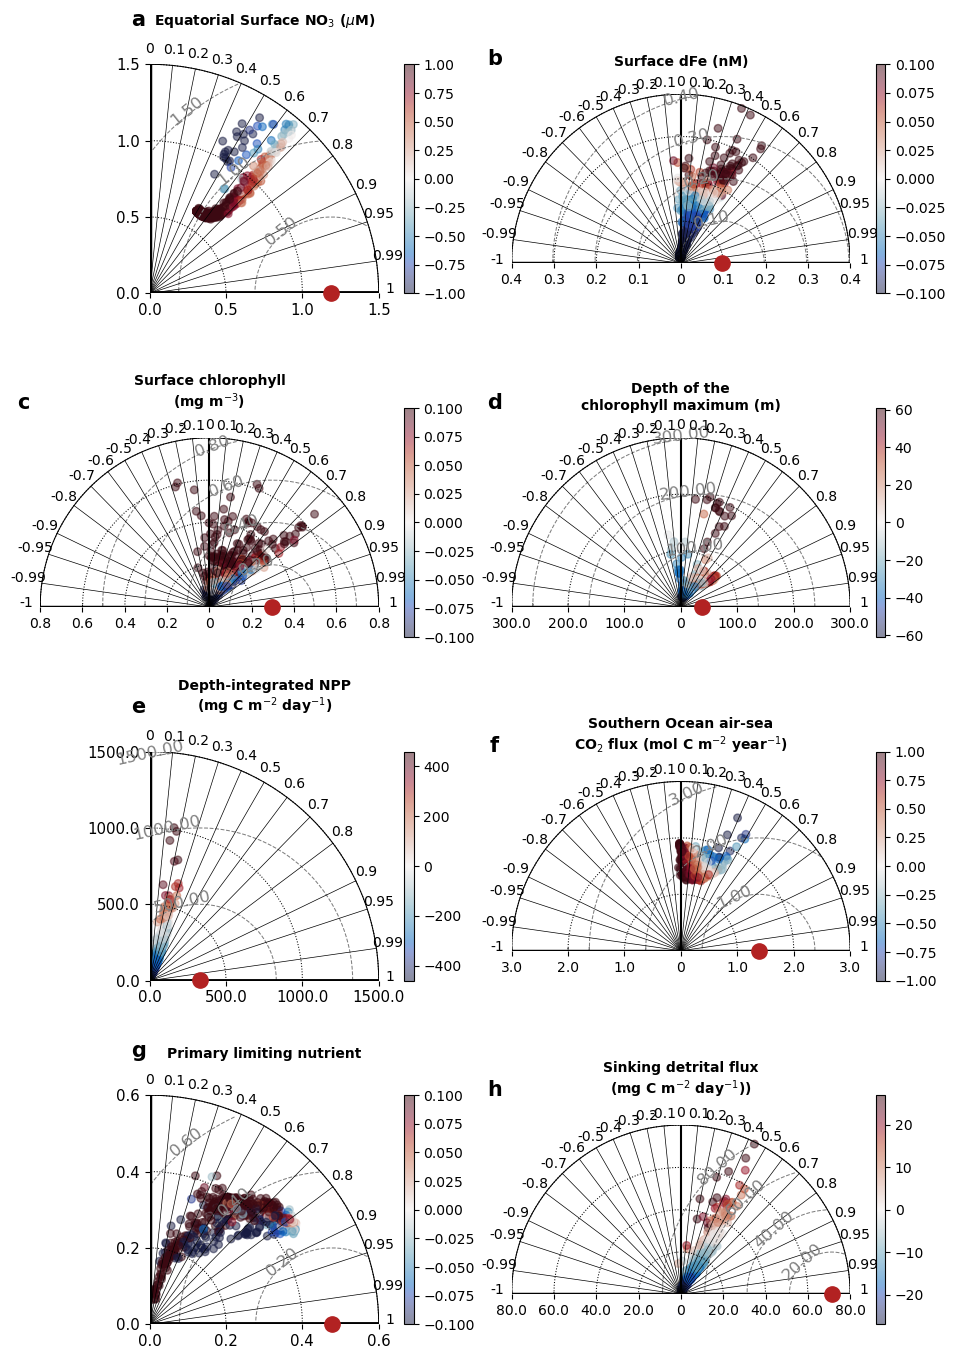

In [75]:

fslab = 15
fstic = 13

labs = ['Equatorial Surface NO$_3$ ($\mu$M)', \
        'Surface dFe (nM)', \
        'Surface chlorophyll\n(mg m$^{-3}$)', \
        'Depth of the\nchlorophyll maximum (m)', \
        'Depth-integrated NPP\n(mg C m$^{-2}$ day$^{-1}$)', \
        'Southern Ocean air-sea\nCO$_2$ flux (mol C m$^{-2}$ year$^{-1}$)', \
        'Primary limiting nutrient', \
        'Sinking detrital flux\n(mg C m$^{-2}$ day$^{-1}$))'
        ] 
letter = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

fig = plt.figure(figsize=(10,14))
gs = GridSpec(4, 2)

for vi,vv in enumerate(var):
    ax = plt.subplot(gs[vi])

    if vv == 'surno3':
        vmin = 0 - np.abs(np.round(np.percentile(stats_eq[vv+'_bias'],0.01),1)*1.2)
        vmax = 0 + np.abs(np.round(np.percentile(stats_eq[vv+'_bias'],0.01),1)*1.2)
        vmin = 0 - np.abs(np.round(np.min(stats_eq[vv+'_bias'])))
        vmax = 0 + np.abs(np.round(np.min(stats_eq[vv+'_bias'])))
        statss = stats_eq
    elif vv == 'fgco2':
        vmin = 0 - np.abs(np.round(np.percentile(stats_so[vv+'_bias'],0.01),1)*1.2)
        vmax = 0 + np.abs(np.round(np.percentile(stats_so[vv+'_bias'],0.01),1)*1.2)
        vmin = 0 - np.abs(np.round(np.min(stats_so[vv+'_bias'])))
        vmax = 0 + np.abs(np.round(np.min(stats_so[vv+'_bias'])))
        statss = stats_so
    else:
        vmin = 0 - np.abs(np.round(np.percentile(stats[vv+'_bias'],0.01),1)*1.2)
        vmax = 0 + np.abs(np.round(np.percentile(stats[vv+'_bias'],0.01),1)*1.2)
        vmin = 0 - np.abs(np.round(np.min(stats[vv+'_bias'])))
        vmax = 0 + np.abs(np.round(np.min(stats[vv+'_bias'])))
        statss = stats

    if vv == 'fgco2':
        sm.taylor_diagram(np.array(statss[vv+'_sdev']), np.array(statss[vv+'_crmsd']), np.array(statss[vv+'_ccoef']), alpha=0.1, 
                          MarkerDisplayed='colorBar', cmapzdata=np.array(statss[vv+'_bias'])*(-1), locationColorBar='EastOutside', titleColorBar=' ', 
                          cmap=lighten(cmo.balance,0.5), cmap_marker='o', markerSize=15, cmap_vmax=vmax, cmap_vmin=vmin, 
                          colRMS='grey', styleRMS='--', widthRMS=0.75, showlabelsRMS='on', titleRMS='off', rmsLabelFormat='0:.2f',
                          colSTD='k', styleSTD=':', widthSTD=0.75, showlabelsSTD='off', titleSTD='off', 
                          colCOR='k', styleCOR='-', widthCOR=0.5, showlabelsCOR='on', titleCOR='off', 
                          markerOBS='o', colOBS='firebrick')
    else:
        sm.taylor_diagram(np.array(statss[vv+'_sdev']), np.array(statss[vv+'_crmsd']), np.array(statss[vv+'_ccoef']), alpha=0.1, 
                          MarkerDisplayed='colorBar', cmapzdata=np.array(statss[vv+'_bias']), locationColorBar='EastOutside', titleColorBar=' ', 
                          cmap=lighten(cmo.balance,0.5), cmap_marker='o', markerSize=15, cmap_vmax=vmax, cmap_vmin=vmin, 
                          colRMS='grey', styleRMS='--', widthRMS=0.75, showlabelsRMS='on', titleRMS='off', rmsLabelFormat='0:.2f',
                          colSTD='k', styleSTD=':', widthSTD=0.75, showlabelsSTD='off', titleSTD='off', 
                          colCOR='k', styleCOR='-', widthCOR=0.5, showlabelsCOR='on', titleCOR='off', 
                          markerOBS='o', colOBS='firebrick')
    
    plt.text(0.5,1.15, labs[vi], transform=ax.transAxes, va='bottom', ha='center', fontweight='bold')
    plt.text(-0.05,1.15, letter[vi], fontweight='bold', fontsize=fslab, ha='center', va='bottom', transform=ax.transAxes)


plt.subplots_adjust(hspace=0.5, wspace=0.1, right=0.95, left=0.05, bottom=0.05, top=0.95)



os.chdir("/home/581/pjb581/gtracer_optimisation")
fig.savefig("assess_performance_TaylorDiagram.png", dpi=300)
fig.savefig("assess_performance_TaylorDiagram.pdf", dpi=300)
fig.savefig("assess_performance_TaylorDiagram_transparent.png", dpi=300, transparent=True)


## print statistics for writing ( and supp Table)

In [76]:
print("Surface NO3 min and max correlation =", df_eq_stats['surno3_ccoef'].iloc[1::].min(), df_eq_stats['surno3_ccoef'].iloc[1::].max())
print("Surface dFe min and max correlation =", df_stats['surfer_ccoef'].iloc[1::].min(), df_stats['surfer_ccoef'].iloc[1::].max())
print("Surface Chl min and max correlation =", df_stats['surchl_ccoef'].iloc[1::].min(), df_stats['surchl_ccoef'].iloc[1::].max())
print("Depth of DCM min and max correlation =", df_stats['chmaxz_ccoef'].iloc[1::].min(), df_stats['chmaxz_ccoef'].iloc[1::].max())
print("Depth-int NPP min and max correlation =", df_stats['intnpp_ccoef'].iloc[1::].min(), df_stats['intnpp_ccoef'].iloc[1::].max())
print("SO CO2 flux dFe min and max correlation =", df_so_stats['fgco2_ccoef'].iloc[1::].min(), df_so_stats['fgco2_ccoef'].iloc[1::].max())
print("Limiting Nutrient min and max correlation =", df_stats['phylim_ccoef'].iloc[1::].min(), df_stats['phylim_ccoef'].iloc[1::].max())
print("Down flux POC min and max correlation =", df_stats['pocsink_ccoef'].iloc[1::].min(), df_stats['pocsink_ccoef'].iloc[1::].max())


Surface NO3 min and max correlation = 0.4326464852444079 0.7137068743543638
Surface dFe min and max correlation = -0.22570633567756723 0.5711605669845871
Surface Chl min and max correlation = -0.35172664618967037 0.8091809198388601
Depth of DCM min and max correlation = -0.18827409732927072 0.7738706519773474
Depth-int NPP min and max correlation = 0.0878622198240374 0.4107285616937723
SO CO2 flux dFe min and max correlation = -0.029241918404105744 0.4967419240737631
Limiting Nutrient min and max correlation = 0.10468289621341047 0.8462325577260245
Down flux POC min and max correlation = -0.07993070747653867 0.6012656869283929


In [77]:
print("Surface NO3 min and max normalised STD =", df_eq_stats['surno3_nsdev'].iloc[1::].min(), df_eq_stats['surno3_nsdev'].iloc[1::].max())
print("Surface dFe min and max normalised STD =", df_stats['surfer_nsdev'].iloc[1::].min(), df_stats['surfer_nsdev'].iloc[1::].max())
print("Surface Chl min and max normalised STD =", df_stats['surchl_nsdev'].iloc[1::].min(), df_stats['surchl_nsdev'].iloc[1::].max())
print("Depth of DCM min and max normalised STD =", df_stats['chmaxz_nsdev'].iloc[1::].min(), df_stats['chmaxz_nsdev'].iloc[1::].max())
print("Depth-int NPP min and max normalised STD =", df_stats['intnpp_nsdev'].iloc[1::].min(), df_stats['intnpp_nsdev'].iloc[1::].max())
print("SO CO2 flux dFe min and max normalised STD =", df_so_stats['fgco2_nsdev'].iloc[1::].min(), df_so_stats['fgco2_nsdev'].iloc[1::].max())
print("Limiting Nutrient min and max normalised STD =", df_stats['phylim_nsdev'].iloc[1::].min(), df_stats['phylim_nsdev'].iloc[1::].max())
print("Down flux POC min and max normalised STD =", df_stats['pocsink_nsdev'].iloc[1::].min(), df_stats['pocsink_nsdev'].iloc[1::].max())


Surface NO3 min and max normalised STD = 0.5112073625956277 1.2206914554626096
Surface dFe min and max normalised STD = 0.11737194425776208 4.051906661823754
Surface Chl min and max normalised STD = 0.024428058647020662 2.248704036308161
Depth of DCM min and max normalised STD = 0.4485584309750288 5.39489515026859
Depth-int NPP min and max normalised STD = 0.005830637384680691 3.080024056439923
SO CO2 flux dFe min and max normalised STD = 0.910930892552693 1.860650565137823
Limiting Nutrient min and max normalised STD = 0.13656224063525393 0.9911106122069546
Down flux POC min and max normalised STD = 0.002302181756034974 1.1093788263021482


In [78]:
print("Surface NO3 min and max bias =", df_eq_stats['surno3_bias'].iloc[1::].min(), df_eq_stats['surno3_bias'].iloc[1::].max())
print("Surface dFe min and max bias =", df_stats['surfer_bias'].iloc[1::].min(), df_stats['surfer_bias'].iloc[1::].max())
print("Surface Chl min and max bias =", df_stats['surchl_bias'].iloc[1::].min(), df_stats['surchl_bias'].iloc[1::].max())
print("Depth of DCM min and max bias =", df_stats['chmaxz_bias'].iloc[1::].min(), df_stats['chmaxz_bias'].iloc[1::].max())
print("Depth-int NPP min and max bias =", df_stats['intnpp_bias'].iloc[1::].min(), df_stats['intnpp_bias'].iloc[1::].max())
print("SO CO2 flux dFe min and max bias =", df_so_stats['fgco2_bias'].iloc[1::].min(), df_so_stats['fgco2_bias'].iloc[1::].max())
print("Limiting Nutrient min and max bias =", df_stats['phylim_bias'].iloc[1::].min(), df_stats['phylim_bias'].iloc[1::].max())
print("Down flux POC min and max bias =", df_stats['pocsink_bias'].iloc[1::].min(), df_stats['pocsink_bias'].iloc[1::].max())


Surface NO3 min and max bias = -1.441247961024949 1.5592744440889488
Surface dFe min and max bias = -0.12820565666066844 0.5084239515831027
Surface Chl min and max bias = -0.2665987572002624 1.2156176791674393
Depth of DCM min and max bias = -60.82232949761352 267.4283706637656
Depth-int NPP min and max bias = -460.1049993938233 843.061421586839
SO CO2 flux dFe min and max bias = -1.4384854504340392 1.6763051028395946
Limiting Nutrient min and max bias = -0.39097744360902253 0.5238095238095237
Down flux POC min and max bias = -27.038371233701515 47.518120720268485
